In [1]:
%matplotlib notebook

In [60]:
%run Cifar10InceptionV3ClusterAndClassify.py
random_state=0
TRAIN_SIZE=500
np.random.seed(random_state)
skf, skf_cv = spliters(random_state, train_size=TRAIN_SIZE, cv_repeats=5)

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1635: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [61]:
from scipy.stats import entropy

# Prototypes as exception memory

Here we want to combine somehow prototypes and the regular CNN predictions to make prototypes be a sort of memory for exceptions.

In [62]:
N = 10
X_imgs, X, y = gen_cifar10(N=N,random_seed=random_state, plot=False)
train, test = next(skf.split(X,y))
train, val = next(skf_cv.split(X[train], y[train]))

In [63]:
X_ex, y_ex = gen_exception(X, y, [0,1], n=2, margin=0.8, radius=0.01)
ex = np.arange(len(train),len(train)+X_ex.shape[0])
X_ex.shape, y_ex.shape, ex

((4, 2048), (4,), array([250, 251, 252, 253]))

In [64]:
X_train, y_train = X[train], y[train]
# X_train = np.concatenate([X[train], X_ex], axis=0)
# y_train = np.concatenate([y[train], y_ex], axis=0)
X_train.shape, y_train.shape

((250, 2048), (250,))

In [99]:
direct = LogisticRegression(random_state=random_state,multi_class='multinomial', solver='lbfgs', C=1e-4)
prototypes = MultiPrototypes(random_state, cluster__n_clusters=200, cluster__n_init=10, cluster__max_iter=400,
                             classify__C=1e-5, verbose=0)

In [100]:
direct.fit(X_train, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

In [101]:
prototypes.fit(X_train, y_train)

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


MultiPrototypes(cachedir='/mnt/Data/tmp/tmpr2r9vegy', random_state=None,
        verbose=None)

In [74]:
def plot_protos(X,y):
    np.random.seed(random_state)
    clusters = prototypes.named_steps.cluster.cluster_centers_
    proj = TSNE(n_components=2, perplexity=20)
    #proj = Isomap(n_components=2, n_neighbors=3)
    data_clusters = np.concatenate([X, clusters])
    data_clusters = proj.fit_transform(data_clusters)
    data, clusters = data_clusters[:X.shape[0],...], data_clusters[X.shape[0]:,...]
    plot2D(data, y)
    for c in clusters:
        plt.plot(c[0], c[1], ms=5,
                 marker='d', linewidth=0, color='k')
plot_protos(X_train, y_train)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


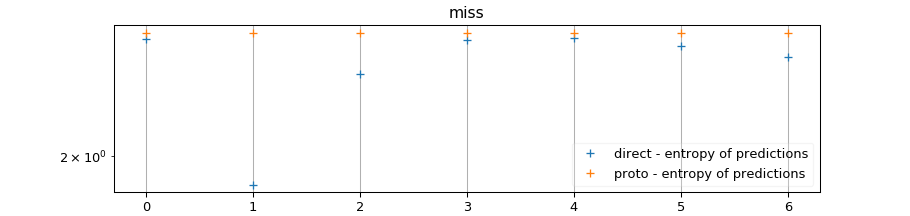

<IPython.core.display.Javascript object>


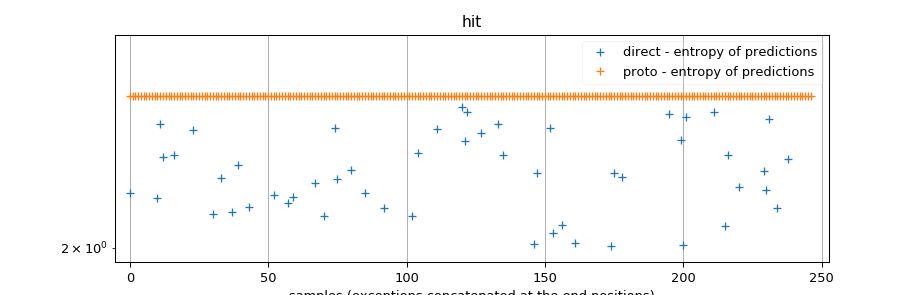

In [55]:
def plot_entropy(X, y, which='miss'):
    plt.figure()
    if which == 'miss':
        mask =(direct.predict(X)!=y)
    elif which == 'hit':
        mask = (direct.predict(X)==y)
    plt.plot(entropy(direct.predict_proba(X[mask]).T), label='direct - entropy of predictions',
            linestyle= 'none', marker='+')
    plt.plot(entropy(prototypes.predict_proba(X[mask]).T), label='proto - entropy of predictions',
            linestyle= 'none', marker='+')
    plt.xlabel("samples (exceptions concatenated at the end positions)")
    plt.legend(loc='best', framealpha=0.2)
    plt.yscale('log')
    plt.grid(which='major', axis='both')
    plt.title(which)
    #plt.plot([len(train)]*2, plt.ylim(), 'k:')
plot_entropy(X_train, y_train, 'miss')
plot_entropy(X_train, y_train, 'hit')
#plot_entropy(X[val], y[val])

In [47]:
prototypes.predict_proba(X_train)

array([[0.10000024, 0.10000026, 0.09999983, ..., 0.09999985, 0.10000004,
        0.10000001],
       [0.10000048, 0.10000137, 0.09999956, ..., 0.09999934, 0.09999994,
        0.10000031],
       [0.09999963, 0.10000823, 0.09999869, ..., 0.09999863, 0.09999958,
        0.0999998 ],
       ...,
       [0.100045  , 0.099995  , 0.099995  , ..., 0.099995  , 0.099995  ,
        0.099995  ],
       [0.099995  , 0.100045  , 0.099995  , ..., 0.099995  , 0.099995  ,
        0.099995  ],
       [0.099995  , 0.100045  , 0.099995  , ..., 0.099995  , 0.099995  ,
        0.099995  ]])

In [56]:
plt.figure()
plt.plot(prototypes.predict_proba(X_train).T)
plt.ylim(0,1)

<IPython.core.display.Javascript object>

(0, 1)

In [26]:
prototypes.named_steps.cluster.transform(X[train])

{'X': array([[2.60541863e-05, 3.10964538e-17],
        [1.54370759e-03, 2.73730191e-13],
        [2.89419352e-10, 4.08259727e-23],
        [3.18083421e-08, 3.37443470e-22],
        [1.60292132e-07, 3.84392642e-21],
        [8.23981998e-04, 3.24906408e-01],
        [5.01759490e-11, 8.12263971e-26],
        [2.28867274e-11, 5.03597159e-27],
        [2.30396285e-08, 1.83862091e-21],
        [7.16851655e-09, 6.58484691e-21],
        [4.30836576e-17, 9.66014141e-35],
        [9.09833555e-05, 2.83933142e-15],
        [5.80656461e-04, 9.02614999e-02],
        [1.04433540e-02, 2.29472837e-05],
        [8.94208199e-08, 2.45056080e-20],
        [9.43472293e-10, 1.49359281e-22],
        [1.11992443e-05, 3.08745912e-18],
        [1.27451861e-04, 9.75575924e-18],
        [5.35261552e-17, 1.79640027e-32],
        [7.45098190e-16, 5.59370050e-34],
        [9.39261064e-13, 1.31632258e-28],
        [2.48544500e-06, 2.81641109e-19],
        [1.72622509e-07, 1.28068196e-18],
        [5.32359306e-06, 1.10

In [75]:
prototypes.score(X_train, y_train)

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


0.636

In [ ]:
direct.score(X[val],y[val])